# 1. Descripción del problema (Problema del camino más corto)

**Entrada**: Un grafo dirigido $G=(V,E)$, un vértice fuente $s\in V$, y un valor real $l_e$ asociado a cada arco $e\in E$.

**Salida**: La distancia más corta $\text{dist}(s,v)$ para cada vértice $v\in V$, o una declaración indicando que $G$ contiene un ciclo negativo.

El problema del camino más corto busca encontrar la menor distancia entre un vértice $s$ y cada nodo de un grafo $G$. La distancia entre nodos es calculada cumando los pesos de los arcos entre ellos.

![image](https://i.imgur.com/xiHLIDk.png)

# 2. Bellman-Ford y Dijkstra

El siguiente código contiene implementaciones del algoritmo de **Bellman-Ford** y del algoritmo de **Dijkstra**

## 2.1. Código

In [99]:
import random as rd
from termcolor import colored
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime
from timeit import repeat
import statistics as st
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from sys import maxsize

In [100]:
# Funciones Auxiliares
def is_valid_edge(generated_edges: dict, i: int, j: int):
    return i != j and not generated_edges.get((i, j), None) and not generated_edges.get((j, i), None)

def graph_to_nxdigraph(graph: list, n: int):
    """
        Input: Un grafo en formato list[tuple]. Ej: [(0, 1, 10), (1, 2, 15), (2, 0, 7)].
        Output: Un nx.DiGraph de la libreria networkx.
    """
    nxdigraph = nx.DiGraph()
    [nxdigraph.add_node(i) for i in range(n)]

    for v in graph:
        nxdigraph.add_edge(v[0], v[1], weight=v[2])

    return nxdigraph

def instance_generator_bell(n: int):
    """
        Input: cantidad de vértices
        Output: una lista que contiene todos los arcos y el número del vértice fuente (la función retorna dos variables).
        Los arcos vienen en la forma (i, j, weight), donde i es el vértice origen del arco y j el vértice al que apunta el arco, mientras que weight es su peso.
    """
    graph = []
    nodes = rd.sample(range(0, n), n)
    unvisited_nodes = rd.sample(range(0, n), n)
    
    generated_edges = {}
    for i in nodes:
        rand = rd.sample(nodes, rd.randint(1, 3))

        for j in rand:
            edge = (i, j)
            edge_with_weight = (i, j, rd.randint(1, 100))
            
            if generated_edges.get((edge[1], edge[0]), None):
                continue
            
            if i == j:
                new_vertice = None
                iterations = 0
                while new_vertice is None and iterations < 250:
                    iterations += 1
                    number = rd.randint(0, n - 1)
                    if is_valid_edge(generated_edges, i, number):
                        new_vertice = number

                if iterations >= 250:
                    return instance_generator_bell(n)
                
                edge = (i, new_vertice)
                edge_with_weight = (i, new_vertice, rd.randint(-25, 100)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
            
            graph.append(edge_with_weight)
            generated_edges[edge] = edge

            if edge_with_weight[1] in unvisited_nodes:
                unvisited_nodes.remove(edge_with_weight[1])

    for i in unvisited_nodes:
        valid_edge = False
        iterations = 0
        while not valid_edge and iterations < 250:
            iterations += 1
            m = rd.randint(0, n - 1)
            if is_valid_edge(generated_edges, m, i):
                valid_edge = True
                edge = (m, i)
                edge_with_weight = (m, i, rd.randint(-25, 100)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
                graph.append(edge_with_weight)
                generated_edges[edge] = edge

        if iterations >= 250:
            return instance_generator_bell(n)

    return graph, graph[0][0]

def instance_generator_dijk(n: int):
    """
        Input: cantidad de vértices
        Output: una lista que contiene todos los arcos y el número del vértice fuente (la función retorna dos variables).
        Los arcos vienen en la forma (i, j, weight), donde i es el vértice origen del arco y j el vértice al que apunta el arco, mientras que weight es su peso.
    """
    graph = []
    nodes = rd.sample(range(0, n), n)
    unvisited_nodes = rd.sample(range(0, n), n)
    
    generated_edges = {}
    for i in nodes:
        rand = rd.sample(nodes, rd.randint(1, 3))

        for j in rand:
            edge = (i, j)
            edge_with_weight = (i, j, rd.randint(1, 100))
            
            if generated_edges.get((edge[1], edge[0]), None):
                continue
            
            if i == j:
                new_vertice = None
                iterations = 0
                while new_vertice is None and iterations < 250:
                    iterations += 1
                    number = rd.randint(0, n - 1)
                    if is_valid_edge(generated_edges, i, number):
                        new_vertice = number

                if iterations >= 250:
                    return instance_generator_dijk(n)
                
                edge = (i, new_vertice)
                edge_with_weight = (i, new_vertice, rd.randint(1, 100)) # 1 y 100 corresponde a los límites de los pesos, puede cambiarlos.
            
            graph.append(edge_with_weight)
            generated_edges[edge] = edge

            if edge_with_weight[1] in unvisited_nodes:
                unvisited_nodes.remove(edge_with_weight[1])

    for i in unvisited_nodes:
        valid_edge = False
        iterations = 0
        while not valid_edge and iterations < 250:
            iterations += 1
            m = rd.randint(0, n - 1)
            if is_valid_edge(generated_edges, m, i):
                valid_edge = True
                edge = (m, i)
                edge_with_weight = (m, i, rd.randint(1, 100)) # 1 y 100 corresponde a los límites de los pesos, puede cambiarlos.
                graph.append(edge_with_weight)
                generated_edges[edge] = edge

        if iterations >= 250:
            return instance_generator_dijk(n)

    return graph, graph[0][0]

def listT_to_matrix(graph, V):
    edges = len(graph)
    newGraph = [[0 for i in range(V)] for j in range(V)]

    for node in range(edges):
        for (x, y, peso) in graph:
            newGraph[x][y] = peso

    return newGraph

def minDistance(V, dist, visited):
    min = maxsize
    min_index = 0

    for u in range(V):
        if dist[u] < min and visited[u] == False:
            min = dist[u]
            min_index = u
    
    return min_index

In [108]:
def bellmanFord(graph, V, E, src, visualize = False, verbose = False):
	if verbose:
		print("-------------------------")
		print("Grafo ingresado: ", graph)
		print("Nodos: ", E)
		print("Vértices: ", V)
		print("Nodo Inicial: ", src)
		print("-------------------------")

	dis = [maxsize] * V
	dis[src] = 0

	if verbose: 
		print("Recorremos desde el nodo inicial a sus nodos adyacentes\n")
	for i in range(V - 1):
		if verbose:
			print("Nodo Actual: ",i)
		for j in range(E):
			if verbose:
				print("Verificamos la distancia entre nodos,", dis[graph[j][0]],"y", graph[j][2],", será menor a", dis[graph[j][1]], "?")
				if dis[graph[j][0]] + graph[j][2] < dis[graph[j][1]]:
					print("Ya que es menor, realizaremos relajación de nodos.")
				print("")
		
			if dis[graph[j][0]] + graph[j][2] < dis[graph[j][1]]:
				dis[graph[j][1]] = dis[graph[j][0]] + graph[j][2]
		if verbose:
			print("-------------------------")
	
	for i in range(E):
		x = graph[i][0]
		y = graph[i][1]
		weight = graph[i][2]
		if dis[x] != maxsize and dis[x] + weight < dis[y]:
			if verbose:
				print("Hay un ciclo de peso negativo en el grafo.")
	if verbose:
		print("Distancia desde la fuente al vértice")
		for i in range(V):
			print("%d\t\t%d" % (i, dis[i]))
	
	if visualize:
		grafo = graph_to_nxdigraph(graph,V)
		pos=nx.spring_layout(grafo,20)
		labels = nx.get_edge_attributes(grafo, "weight")
		nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels,font_size=14)
		nx.draw(grafo,pos, with_labels=True, node_size=800, font_color="white", font_size=14, font_weight="black", width=2.0, edge_color="black", node_color ="green")



In [102]:
def dijkstra(graph, V ,src, verbose = False):
  if verbose:
    print("-------------------------")
    print("Grafo ingresado: ", graph)
    print("Vértices: ", V)
    print("Nodo Inicial: ", src)
    print("-------------------------")

  dist = [maxsize] * V
  dist[src] = 0
  sptSet = [False] * V
  
  if verbose:
    print("Recorremos desde el nodo inicial a sus nodos adyacentes\n")

  for cout in range(V):
    x = minDistance(V, dist, sptSet)
    if verbose:
      print("Distancia mínima: ", x)
    sptSet[x] = True
    if verbose:
      print("Marcamos el nodo como visitado")

    for y in range(V):
      if verbose:
        print("Iteramos buscando el camino más corto y lo guardamos en cada iteración")
        if graph[x][y] > 0 and sptSet[y] == False and dist[y] > dist[x] + graph[x][y]:
          print(dist[y],"=",dist[x] + graph[x][y],"\n")
        else:
          print("No se cumple nuestra condición (graph[x][y] > 0 and sptSet[y] == False and dist[y] > dist[x] + graph[x][y])")
          print("Continuamos en la siguiente iteración...\n")

      if graph[x][y] > 0 and sptSet[y] == False and dist[y] > dist[x] + graph[x][y]:
        dist[y] = dist[x] + graph[x][y]
    if verbose:
      print("-------------------------")
  if verbose:  
    print("Distancia desde la fuente al vértice")
    for node in range(V):
      print(node, "\t", dist[node])

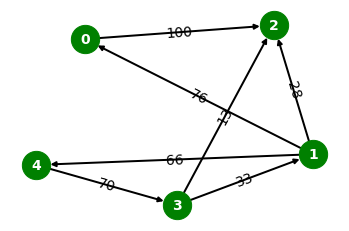

In [110]:
g, v = instance_generator_bell(5)
bellmanFord(g, 5, len(g), 0, True) 

## 2.2. Descripción del algoritmo

### 2.2.1 Algoritmo de Bellman-Ford

El algoritmo de Bellman-Ford recibe un grafo dirigido $G$ de $n$ vértices y un nodo de inicio $s$. Además, cada arco del grafo posee un peso/distancia asignado. Si existen ciclos negativos, el algoritmo retorna una lista vacía, en caso contrario, el algoritmo retorna una lista con la distancia mínima entre el nodo inicial y el resto de los nodos del grafo. El algoritmo funciona de la siguiente manera:

1. Creamos una lista para guardar la distancia mínima del nodo inicial $s$ al resto de nodos, inicializando los valores en $\infty$. El nodo $s$ es una excepción, ya que siendo el nodo inicial recibe una distancia de 0.

2. Se itera $V - 1$ veces hasta que no existan más cambios en las distancias o hayamos iterado por todos los arcos.

3. Para cada arco $(u,v)$ se calcula la distancia de $s$ a $v$ como $\text{dist}(s, v) = \text{dist}(s, u) + w(u, v)$, donde $w(u, v)$ es el peso del arco $(u, v)$. Si la distancia calculada es menor a la actual, actualizamos el valor.

4. Al terminar las iteraciones, hacemos una última iteracion para asegurarnos de que no existan ciclos negativos. Si existe alguno (Si recibimos una distancia menor a una previamente calculada para cualquier arco $(u,v)$), se retorna una lista vacía. En caso contrario, retornamos la lista con las distancias obtenidas.

### 2.2.2 Algoritmo de Dijkstra

El algoritmo de Dijkstra recibe un grafo $G$ de $n$ vértices y un nodo de inicio $s$. Además, cada arco del grafo posee un peso/distancia **no negativo** asignado. El algoritmo retorna una lista con la distancia mínima entre el nodo inicial y el resto de los nodos del grafo. El algoritmo funciona de la siguiente manera:

1. Creamos una lista para guardar la distancia mínima del nodo inicial $s$ al resto de nodos, inicializando los valores en $\infty$. El nodo $s$ es una excepción, ya que siendo el nodo inicial recibe una distancia de 0.

2. Insertamos los nodos del grafo en una cola de prioridad ordenada por distancias.

3. Mientras la cola tenga elementos, obtenemos el nodo $u$ con menor distancia, lo eliminamos de la cola y lo marcamos como visitado. Si el nodo ya había sido visitado, lo eliminamos y continuamos con el siguiente.

3. Calculamos la distancia a cada nodo adyacente $v$ no visitado como $\text{dist}(s, v) = \text{dist}(s, u) + w(u, v)$, donde $w(u, v)$ es el peso del arco $(u, v)$. Si la distancia calculada es menor a la actual, actualizamos el valor y volvemos a insertar el nodo a la cola con prioridad.

4. Al terminar las iteraciones, retornamos la lista con las distancias previamente calculadas.


## 2.3 Ejemplo (Bellman-Ford)

## 2.4. Ejecución del algoritmo paso a paso (`verbose=True`)

Usando la opción `verbose=True`, podemos ver lo que ocurre en cada iteración del algoritmo.

### 2.4.1 Bellman-Ford

In [103]:
g, v = instance_generator_bell(5)
bellmanFord(g, 5, len(g), 0, False, True)  

-------------------------
Grafo ingresado:  [(3, 4, 92), (4, 1, 56), (1, 3, 50), (1, 2, 71), (1, 0, 88), (0, 2, 98), (2, 4, 75)]
Nodos:  7
Vértices:  5
Nodo Inicial:  0
-------------------------
Recorremos desde el nodo inicial a sus nodos adyacentes

Nodo Actual:  0
Verificamos la distancia entre nodos, 9223372036854775807 y 92 , será menor a 9223372036854775807 ?

Verificamos la distancia entre nodos, 9223372036854775807 y 56 , será menor a 9223372036854775807 ?

Verificamos la distancia entre nodos, 9223372036854775807 y 50 , será menor a 9223372036854775807 ?

Verificamos la distancia entre nodos, 9223372036854775807 y 71 , será menor a 9223372036854775807 ?

Verificamos la distancia entre nodos, 9223372036854775807 y 88 , será menor a 0 ?

Verificamos la distancia entre nodos, 0 y 98 , será menor a 9223372036854775807 ?
Ya que es menor, realizaremos relajación de nodos.

Verificamos la distancia entre nodos, 98 y 75 , será menor a 9223372036854775807 ?
Ya que es menor, realizaremo


### 2.4.2 Dijkstra

In [104]:
g, v = instance_generator_dijk(3)
grafo2 = listT_to_matrix(g, 3)
dijkstra(g, len(grafo2), 0, True)

-------------------------
Grafo ingresado:  [(2, 1, 26), (1, 0, 18), (0, 2, 1), (0, 2, 49)]
Vértices:  3
Nodo Inicial:  0
-------------------------
Recorremos desde el nodo inicial a sus nodos adyacentes

Distancia mínima:  0
Marcamos el nodo como visitado
Iteramos buscando el camino más corto y lo guardamos en cada iteración
No se cumple nuestra condición (graph[x][y] > 0 and sptSet[y] == False and dist[y] > dist[x] + graph[x][y])
Continuamos en la siguiente iteración...

Iteramos buscando el camino más corto y lo guardamos en cada iteración
9223372036854775807 = 1 

Iteramos buscando el camino más corto y lo guardamos en cada iteración
9223372036854775807 = 26 

-------------------------
Distancia mínima:  1
Marcamos el nodo como visitado
Iteramos buscando el camino más corto y lo guardamos en cada iteración
No se cumple nuestra condición (graph[x][y] > 0 and sptSet[y] == False and dist[y] > dist[x] + graph[x][y])
Continuamos en la siguiente iteración...

Iteramos buscando el camino 

# 3. Tiempo de ejecución

## 3.1 Bellman-Ford

### Teorema: tiempo de ejecución

El algoritmo *Bellman-Ford* tiene un un tiempo de ejecución $O(V \cdot E)$ en el caso promedio, $O(E)$ en el mejor caso y $O(V^3)$ en el peor caso.

### Prueba del teorema

Podemos obtener la complejidad temporal promedio del algoritmo fácilmente analizando las operaciones que este realiza:

1. Inicializa la distanca para cada nodo del grafo, esto conlleva una complejidad temporal de $O(V)$.

2. Las $V - 1$ iteraciones por todos los arcos del grafo conlleva una complejidad temporal $O(V \cdot E)$

3. La iteración adicional por todos los arcos para confirmar si hay ciclos negativos conlleva una complejidad temporal $O(E)$

Esto significa que nuestra conplejidad temporal es $O(V) + O(V \cdot E) + O(E) = O(V \cdot E)$

#### **Mejor caso**

Nuestro mejor caso occure en el caso de que se nos entregue un grafo que se recorra de izquierda a derecha, de tal forma que la distancia a cada nodo anterior $u$ será siempre calculada correctamente, y de tal manera podramos calcular la distancia óptima a un nodo $v$ inmediatamente.

En un caso así, solo necesitaremos 2 iteraciones por los arcos. Una para calcular los valores óptimos, y la de verificación de ciclos negativos. Entonces nuestra complejidad temporal sería $O(E)$.

#### **Peor caso**

En cambio, nuestro peor caso occure cuando nuestro grafo de entrada posea una cantidad de arcos con complejidad cuadrática. Por ejemplo, un grafo completo, los cuales con grafos en los que cada par de vértices tiene una conexión por arista.

Un grafo completo no dirigido tiene una cantidad de conexiones calculada como $V(V-1)/2$, mientras que los dirigidos tienen $V(V-1)$ conexiones.

Si el grafo también posee ciclos negativos, la cantidad de iteraciones será $V - 1$, lo cual nos deja con una complejidad temporal final para este caso de $O(V) \cdot O(V^2) = O(V^3)$.


## 3.2 Dijkstra

### Teorema: tiempo de ejecución

El algoritmo *Dijkstra* tiene un un tiempo de ejecución $O(E \log{V})$ al utilizar una cola de prioridad implementada con un montículo binario.

### Prueba del teorema

Similarmente a la demostración previa, podemos obtener la complejidad temporal del algoritmo analizándolo paso por paso:

1. Insertar los nodos a una cola de prioridad posee una complejidad temporal $O(V) \cdot O(\log{V}) = O(V \log{V})$

2. Obtener y eliminar los elementos menoes del montículo uno por uno posee una complejidad temporal $O(V) \cdot O(\log{V}) = O(V \log{V})$

3. Obtener los nodos adyacentes de cada nodo significa que debemos pasar por todos sus arcos. Entonces, calcular la distancia a todos los nodos adyacentes y volver a insertarlos al montículo posee un tiempo de ejecución $O(E) \cdot O(\log{V}) = O(E \log{V})$.

Por el análisis previo, podemos decir que el algoritmo posee una complejidad temporal de:

$O(V \log{V}) + O(V \log{V}) + O(E \log{V}) = O(E \log{V})$

# 4. Correctitud (Bellman-Ford)


## Teorema: Correctitud del algoritmo Bellman-Ford

El algoritmo *Bellman-Ford* recibe un grafo en forma de lista, su cantidad de nodos, arcos y un nodo $s$ que se usará como nodo fuente y retorna una lista con las distancias de los caminos más cortos desde $s$ hasta cada otro nodo del grafo.


## **Prueba del Teorema**

Para probar el teorema anterior, utilizaremos inducción matemática basándose en la siguiente hipótesis.

"En la i-ésima iteración del algoritmo, la distancia de $s$ a cada nodo $v$ separado como máximo por $i$ arcos es igual a la distancia del camino más corto."

##### **Caso base ($n = 1$)**

Si el grafo ingresado sólo posee un único nodo, entonces la lista de distancias retornadas también tendrá un único valor, el cuál será igual a 0, ya que la distancia del nodo fuente  𝑠  a si mismo, es igual a 0.

##### **Caso inductivo ($n > 1$)**

Al comienzo de la iteración $i + 1$, la distancia actual de $s$ a $v$, corresponde a la distancia del camino más corto con máximo $i$ arcos. Sin embargo, al considerar un arco adicional, podría existir un nuevo valor que minimice esta distancia. Por lo tanto, existen dos casos posibles:

El camino más corto de $s$ a $v$ está formado por $i$ arcos o menos. En este caso, ningún camino de $s$ a $v$ formado exactamente por $i + 1$ arcos minimizará la distancia, por lo tanto, se mantiene el valor de la iteración anterior.

El camino más corto de $s$ a $v$ está formado exactamente por $i + 1$ arcos. Para este caso, consideremos un nodo $w$ predecesor de $v$, tal que el camino de $s$ a $w$ está formado por $i$ arcos. Por inducción, sabemos que la distancia al nodo $w$ es óptima, luego, al sumar este valor con el peso del arco $(w, v)$ se obtendrá una nueva distancia para $v$. Como en cada iteración se recorren todos los arcos del grafo, sabemos que uno de estos arcos $(w, v)$ será el que minimice la distancia a $v$.

##### **Correctitud**

Finalmente, como el caso base y paso inductivo son correctos, y sabiedo que la sub-estructura óptima del problema permite saber que todos los caminos almacenados serán los más cortos, se concluye que el teorema de correctitud del algoritmo es correcto, por lo que el algoritmo también lo es.

# 5. Experimentos

## 5.1 Bellman-Ford (tiempo de ejecución)

A continuación realizaremos experimentos para el algoritmo Bellman-Ford donde calcularemos su tiempo de ejecución en un intervalo de valores desde el 5 hasta el 50.

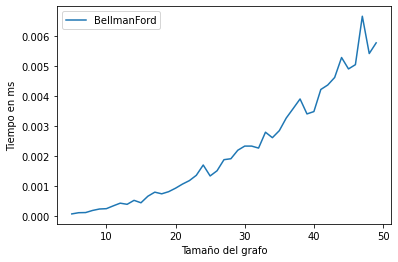

In [105]:
x=[]; y=[];

for n in range(5,50):
  g,a=instance_generator_bell(n)
  t = repeat(setup="from __main__ import bellmanFord", stmt=f"bellmanFord({g},{n}, {len(g)},{0})", repeat=1, number=10)
  x.append(n)
  y.append(t)

plt.plot(x,y)
plt.legend(["BellmanFord"])
plt.xlabel('Tamaño del grafo')
plt.ylabel('Tiempo en ms')
plt.show()

### Análisis de resultados

Podemos apreciar en el gráfico previo que esta sigue una forma similar a la previamente explicada (esta siendo $O(V \cdot E)$) ya que usualmente la cantidad de arcos y vértices son iguales, que viene siendo lo mismo que $v \cdot v$ (una forma exponencial). Entonces podemos confirmar que los resultados son similares a los teóricos.

## 5.2 Bellman-Ford vs Dijkstra (Tiempo de Ejecución)

A continuación se muestra un gráfico en el que se comparan los tiempos de ejecución de los algoritmos de Bellman-Ford y Dijkstra para tamaños de problemas con n ∈ [5, 50].



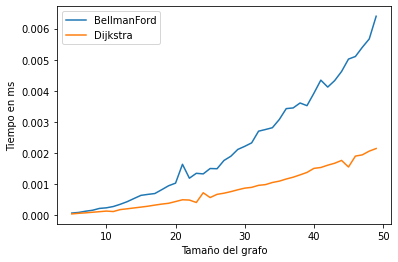

In [106]:
x=[];
y=[];
z=[];

for n in range(5,50):
  g, a = instance_generator_bell(n)
  g2, a = instance_generator_dijk(n)
  g3 = listT_to_matrix(g2, n)
  t = repeat(setup="from __main__ import bellmanFord", stmt=f"bellmanFord({g},{n}, {len(g)},{0})", repeat=1, number=10)
  k = repeat(setup="from __main__ import dijkstra", stmt=f"dijkstra({g3},{len(g3)}, {0})", repeat=1, number=10)
  x.append(n)
  y.append(t)
  z.append(k)
plt.plot(x,y)
plt.plot(x,z)

plt.legend(["BellmanFord","Dijkstra"])
plt.xlabel('Tamaño del grafo')
plt.ylabel('Tiempo en ms')
plt.show()

### Análisis de resultados

En el previo gráfico, podemos apreciar que el algoritmo de Bellman-Ford se posiciona sobre el de Dijkstra, esto es debido a lo explicado previamente sobre la descripción de ambos algoritmos.

Como el algoritmo de Dijkstra soluciona el camino más ópttimo para grafos sin arcos negativos, este tarda menos en realizar la convergencia al camino más óptimo. Bellman-Ford en contrario debe solucionar todos los caminos óptimos posibles para cada nodo **incluyendo** los que tengan arcos negativos.